<a href="https://colab.research.google.com/github/Xwu2023/uYouPlus/blob/main/Copy_of_mosquitos_Xuetao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import pdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [62]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import numpy as np
import scipy.ndimage
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

def snv(data):
    """
    SNV normalization of the spectra

    data: unormalized spectra of size N x D
    idx: A 1-d boolean array of size D
         corresponding to the spectral range for normalization

    output: normalized data
    """
    subdata = data
    mean = subdata.mean(axis=1, keepdims=True)
    std = subdata.std(axis=1, keepdims=True)

    data_normalized = (data-mean)/std

    return data_normalized



def norris_2nd(data, segment, gap):
    """
    Norris second derivative filter

    data: noisy spectra of size N x D
    segment: length of averaging
    gap: gap for central differences
    Details: https://journals.sagepub.com/doi/10.1255/nirn.611

    output: filtered 2nd derivative spectra
    """

    filter = [np.ones(segment),
              np.zeros(gap),
              np.ones(segment) * -2,
              np.zeros(gap),
              np.ones(segment)]
    filter = np.hstack(filter)

    filtered_data = scipy.ndimage.convolve1d(data, filter, axis=1)

    # throw away begining and end
    starting_idx = segment + gap + (segment-1)//2
    filtered_data = filtered_data[:, starting_idx:-starting_idx]

    return filtered_data


def mahalanobis_train(data, label, num_classes, num_components):
    """
    Use training data to derive the mahalanobis distance to each class center

    data: spectra of size N x D
    label: label of size N, taking value in [0, ..., num_classes-1]
    num_classes: number of classes
    num_components: number of PC

    output: a list of PCAs of size num_classes
            output[i] = pca[i], which stores the class mean info
    """
    output = []
    for i in np.arange(num_classes):
        data_now = data[label==i, :]
        pca_now = PCA(n_components = num_components)
        pca_now.fit(data_now)
        output.append(pca_now)

    return output


def mahalanobis_calculate(data, pca_list):
    """
    Calculating the mahalanobis distance to class means

    data: spectra of size N x D
    pca_list: a list of PCA of size num_classes

    output: an array of size N x num_classes
            each entry is the mahalanobis distance to the class mean
    """

    num_classes = len(pca_list)
    N = data.shape[0]
    output = np.zeros([N, num_classes])

    for i in np.arange(num_classes):
        pca_now = pca_list[i]
        feature = pca_now.transform(data)
        normalized_feature = feature / pca_now.singular_values_
        distance_now = np.linalg.norm(normalized_feature, axis=1)
        output[:, i] = distance_now

    return output


def calculate_r2(y_pred, y_true):
    """
    Calculating R2
    """
    u = ((y_true - y_pred)** 2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()

    return 1-u/v

def calculate_RMSE(y_pred, y_true):
    """
    Calculating root mean square error
    """
    rmse = (((y_pred - y_true)**2).mean())**.5
    return rmse

In [64]:
%config InlineBackend.figure_format = 'retina'

In [65]:
choose_range = True
normalize = True    # normalizing the data?
norris_filter = True

In [66]:
### Xuetao R_S Data ###
ages = ['in24', 'unin24']
data_train = []
data_test = []
label_train = []
label_test = []

for ii, age in enumerate(ages):
    df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/malaria_infected_24_portable.xlsx', sheet_name=str(age))
    data_now = df.values[209:935, 2:].transpose()  # spectral range: 500-1700 #Portable 70-512
    label_now = np.ones(data_now.shape[0]) * ii

    # Calculate the number of samples that 70% of the current age group represents
    train_size = int(0.6 * data_now.shape[0])

    # Split the current age group's data and labels
    data_train_now = data_now[:train_size]
    data_test_now = data_now[train_size:]
    label_train_now = label_now[:train_size]
    label_test_now = label_now[train_size:]

    # Append to the overall lists
    data_train.append(data_train_now)
    data_test.append(data_test_now)
    label_train.append(label_train_now)
    label_test.append(label_test_now)

spectral_range=df.values[209:935,0]
data_train = np.vstack(data_train)
data_test = np.vstack(data_test)
label_train = np.hstack(label_train)
label_test = np.hstack(label_test)


In [67]:
print("Train samples:", data_train.shape[0])
print("Test samples:", data_test.shape[0])
print("Rows with any NaN (train):", np.isnan(data_train).any(axis=1).sum())
print("Rows with any NaN (test):", np.isnan(data_test).any(axis=1).sum())

Train samples: 648
Test samples: 432
Rows with any NaN (train): 0
Rows with any NaN (test): 0


In [68]:
data_train.shape

(648, 303)

In [69]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'constant'
data_train = imputer.fit_transform(data_train)
data_test = imputer.transform(data_test)

In [70]:
# Save the preprocessed data
np.savez('/content/drive/My Drive/Colab Notebooks/malaria_infected_24_portable.npz',
         data_train=data_train, data_test=data_test,
         label_train=label_train, label_test=label_test, spectral_range=spectral_range)

In [71]:
import numpy as np

# Load the preprocessed data
data = np.load('/content/drive/My Drive/Colab Notebooks/malaria_infected_24_portable.npz')

data_train = data['data_train']
data_test = data['data_test']
label_train = data['label_train']
label_test = data['label_test']
spectral_range = data['spectral_range']

# Check the loaded data
print(data_train.shape)
print(data_test.shape)
print(label_train.shape)
print(label_test.shape)
print(spectral_range.shape)

(648, 303)
(432, 303)
(648,)
(432,)
(303,)


In [72]:
if choose_range:

    chosen_range_1 = ((spectral_range<=1850) & (spectral_range>=450))
    #chosen_range_2 = ((spectral_range<=1950) & (spectral_range>=1550))
    #chosen_range_3 = ((spectral_range<=1286) & (spectral_range>=1163))

    chosen_range = chosen_range_1 #| chosen_range_2 #| chosen_range_3

    data_train = data_train[:, chosen_range]
    data_test = data_test[:, chosen_range]

if normalize:
    data_train = snv(data_train)
    data_test = snv(data_test)



if norris_filter:
    segment = 9
    gap = 9
    data_train = norris_2nd(data_train, segment, gap)
    data_test = norris_2nd(data_test, segment, gap)
    # Attention: change spectral range
    starting_idx = segment + gap + (segment-1)//2
    spectral_range = spectral_range[starting_idx:-starting_idx]

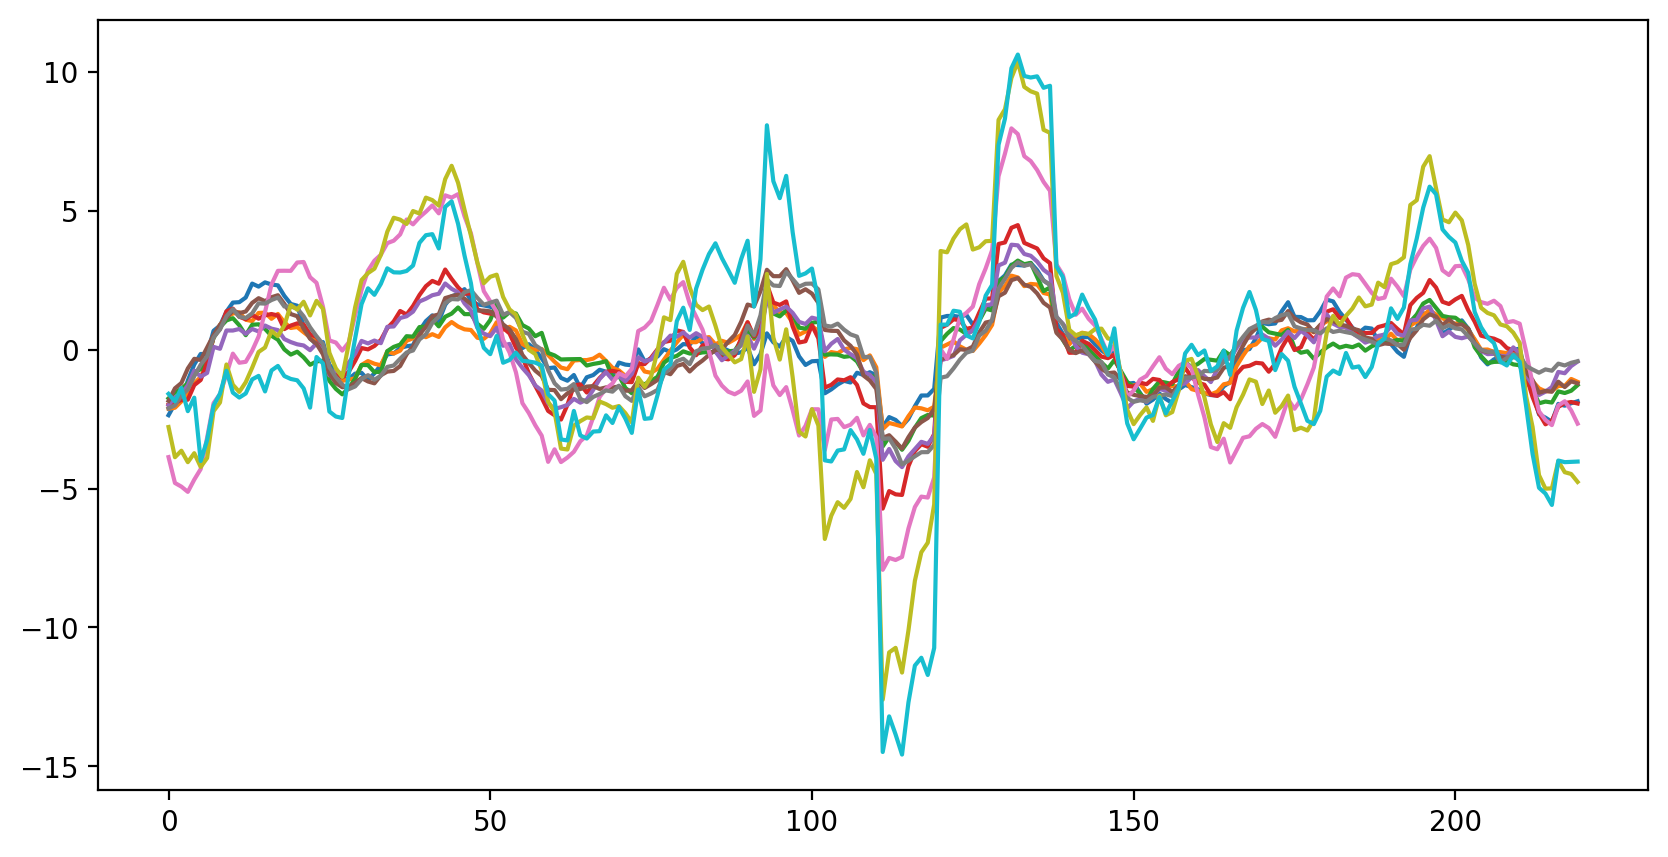

In [73]:
plt.figure(figsize=(10, 5))
for i in range(10):
  plt.plot(data_train[i*20])
plt.show()

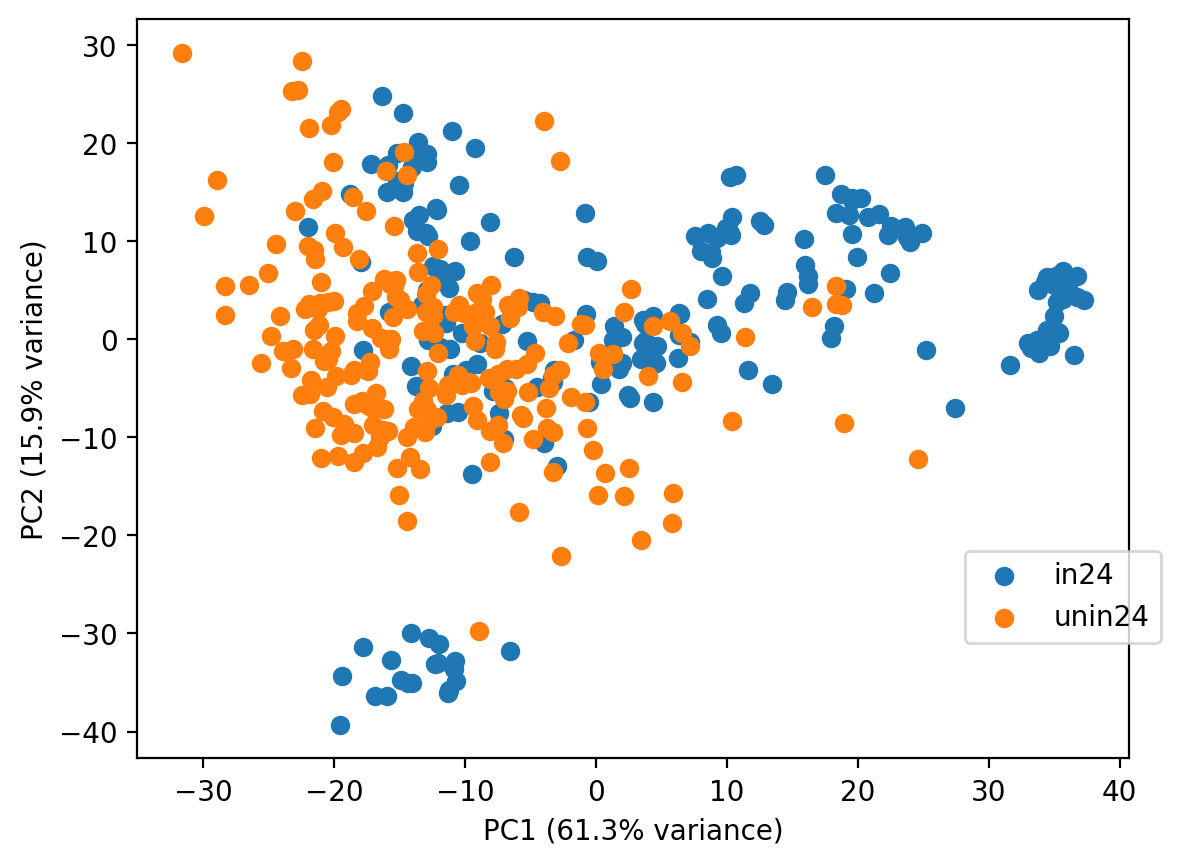

In [74]:
### PCA before ANN training ###
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on training data
pca = PCA(n_components=2)
pca.fit(data_train)

# Transform test data
data_test_pca = pca.transform(data_test)

# Plot PCA-transformed test data
fig, ax = plt.subplots()
for ii in range(len(ages)):
    idx = np.where(label_test == ii)
    ax.scatter(data_test_pca[idx, 0], data_test_pca[idx, 1], label=str(ages[ii]))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.legend(loc='upper left', bbox_to_anchor=(0.82, 0.3))
plt.show()

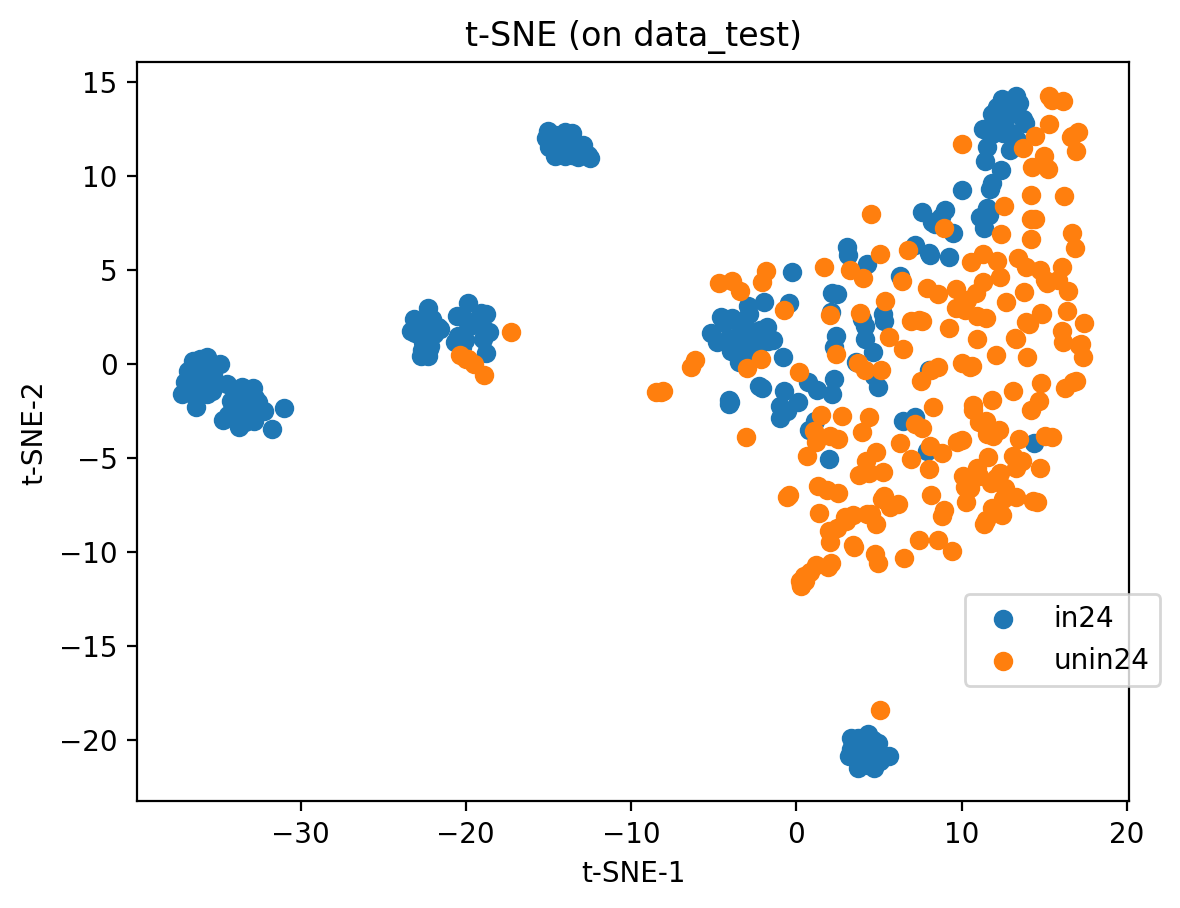

In [75]:
### t-sne before ANN training ###
from sklearn.manifold import TSNE

# Apply t-SNE directly to test data
tsne = TSNE(n_components=2, random_state=42)
data_test_tsne = tsne.fit_transform(data_test)

# Plot t-SNE result
fig, ax = plt.subplots()
for ii in range(len(ages)):
    idx = np.where(label_test == ii)
    ax.scatter(data_test_tsne[idx, 0], data_test_tsne[idx, 1], label=str(ages[ii]))

ax.set_xlabel('t-SNE-1')
ax.set_ylabel('t-SNE-2')
ax.set_title('t-SNE (on data_test)')
ax.legend(loc='upper left', bbox_to_anchor=(0.82, 0.3))
plt.show()

In [76]:
## PCA analysis without ANN training
pca = PCA(n_components=10)
pca.fit(data_train)
feature_train = pca.transform(data_train)
feature_test = pca.transform(data_test)

In [77]:
## PCA based accuracy without ANN training
pca_list = mahalanobis_train(feature_train, label_train, num_classes=len(ages), num_components=10)

# calculate training accuracy

distance_train = mahalanobis_calculate(feature_train, pca_list)
predict_train = np.argmin(distance_train, axis=1)
acc_train = (predict_train == label_train).sum()/len(label_train)

print('Train accuracy: %.2f'% (acc_train*100))

# calculate testing accuracy

distance_test = mahalanobis_calculate(feature_test, pca_list)
predict_test = np.argmin(distance_test, axis=1)
acc_test = (predict_test == label_test).sum()/len(label_test)

print('Test accuracy: %.2f'% (acc_test*100))

Train accuracy: 89.66
Test accuracy: 67.13


In [78]:
dim_hidden = 100 # num of hidden units in the neural network classifier
num_layers = 2 # num of hidden layers
num_classes = len(ages)
num_epochs = 10000

# Below is the ANN part

In [79]:
data_train.shape

(648, 220)

In [80]:
device = torch.device('cpu')

## data ##
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

label_train = torch.tensor(label_train, dtype=torch.int64).to(device)
label_test = torch.tensor(label_test, dtype=torch.int64).to(device)

In [81]:
#### Save best parameters ####
import torch
import numpy as np
from torch import nn

## model ##
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers

feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)

model = nn.Sequential(
    feature_extractor,
    nn.Linear(dim_hidden, num_classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

best_acc_test = 0.0  # Initialize the best test accuracy
best_model_state = None  # Placeholder for the best model state

## full-batch training
for epoch in np.arange(num_epochs):

    # compute prediction error
    pred = model(data_train)
    loss = loss_fn(pred, label_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999:
        # training
        loss_train = loss.item()
        num_correct_train = (pred.argmax(1) == label_train).type(torch.float).sum().item()
        acc_train = num_correct_train / data_train.shape[0]

        # testing
        pred_test = model(data_test)
        num_correct_test = (pred_test.argmax(1) == label_test).type(torch.float).sum().item()
        acc_test = num_correct_test / data_test.shape[0]

        # Save the best model
        if acc_test > best_acc_test:
            best_acc_test = acc_test
            best_model_state = model.state_dict()  # Save model's parameters

        print("Epoch = %d| Loss_train: %.4f | Acc_train: %.2f | Acc_test: %.2f" % (epoch, loss_train, acc_train, acc_test))

# Save the best model to a file
torch.save(best_model_state, "best_model.pth")

# Load the best model for evaluation (optional)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_last = model(data_test)
    label_test_last = label_test

Epoch = 999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 1999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 2999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 3999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 4999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 5999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 6999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 7999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 8999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76
Epoch = 9999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.76


In [82]:
model.eval()
with torch.no_grad():
    # Make predictions on test data
    pred_test_last = model(data_test)
    pred_labels = pred_test_last.argmax(1)
    true_labels = label_test

    # Create a DataFrame to store predictions and true labels
    results_df = pd.DataFrame({
        'Predicted': pred_labels.cpu().numpy(),  # Move to CPU if using a GPU
        'True': true_labels.cpu().numpy()
    })


In [83]:
import pandas as pd
import numpy as np

label_mapping = {i: age for i, age in enumerate(ages)}

# Assuming you already have the `results_df` DataFrame
# Map the 'True' and 'Predicted' columns to the corresponding age labels
results_df['True'] = results_df['True'].map(label_mapping)
results_df['Predicted'] = results_df['Predicted'].map(label_mapping)

# Create a column for chunking every 20 rows
results_df['mosquitoes'] = (np.arange(len(results_df)) // 20) + 1

# Now group by both the 'True' (age) label and 'mosquitoes'
grouped = results_df.groupby(['True', 'mosquitoes'])['Predicted'].value_counts(normalize=True).mul(100).unstack()

# Fill NaN values with 0 (if some predicted labels are not present)
grouped = grouped.fillna(0)

# Round to zero decimal places and add percentage symbol
grouped = grouped.round(0).astype(str) + '%'

# Sort by 'True' (day) labels using the custom age order
grouped_sorted = grouped.reindex(ages, level='True', fill_value=0)

# Sort the columns (Predicted) in the same age order
grouped_sorted = grouped_sorted.reindex(columns=ages, fill_value=0)

# Save the sorted grouped DataFrame to a CSV file
grouped_sorted.to_csv("sorted_grouped_by_age_and_chunk.csv")


In [84]:
loaded_grouped = pd.read_csv("sorted_grouped_by_age_and_chunk.csv",index_col=[0, 1])
loaded_grouped.columns.name = 'Predicted'
loaded_grouped

Predicted           in24  unin24
True   mosquitoes               
in24   1           90.0%   10.0%
       2           80.0%   20.0%
       3           95.0%    5.0%
       4           80.0%   20.0%
       5           30.0%   70.0%
       6           80.0%   20.0%
       7           40.0%   60.0%
       8           90.0%   10.0%
       9           55.0%   45.0%
       10          45.0%   55.0%
       11          38.0%   62.0%
unin24 11           0.0%  100.0%
       12          15.0%   85.0%
       13          10.0%   90.0%
       14          20.0%   80.0%
       15           0.0%  100.0%
       16          10.0%   90.0%
       17           0.0%  100.0%
       18           0.0%  100.0%
       19           0.0%  100.0%
       20           0.0%  100.0%
       21          50.0%   50.0%
       22          67.0%   33.0%

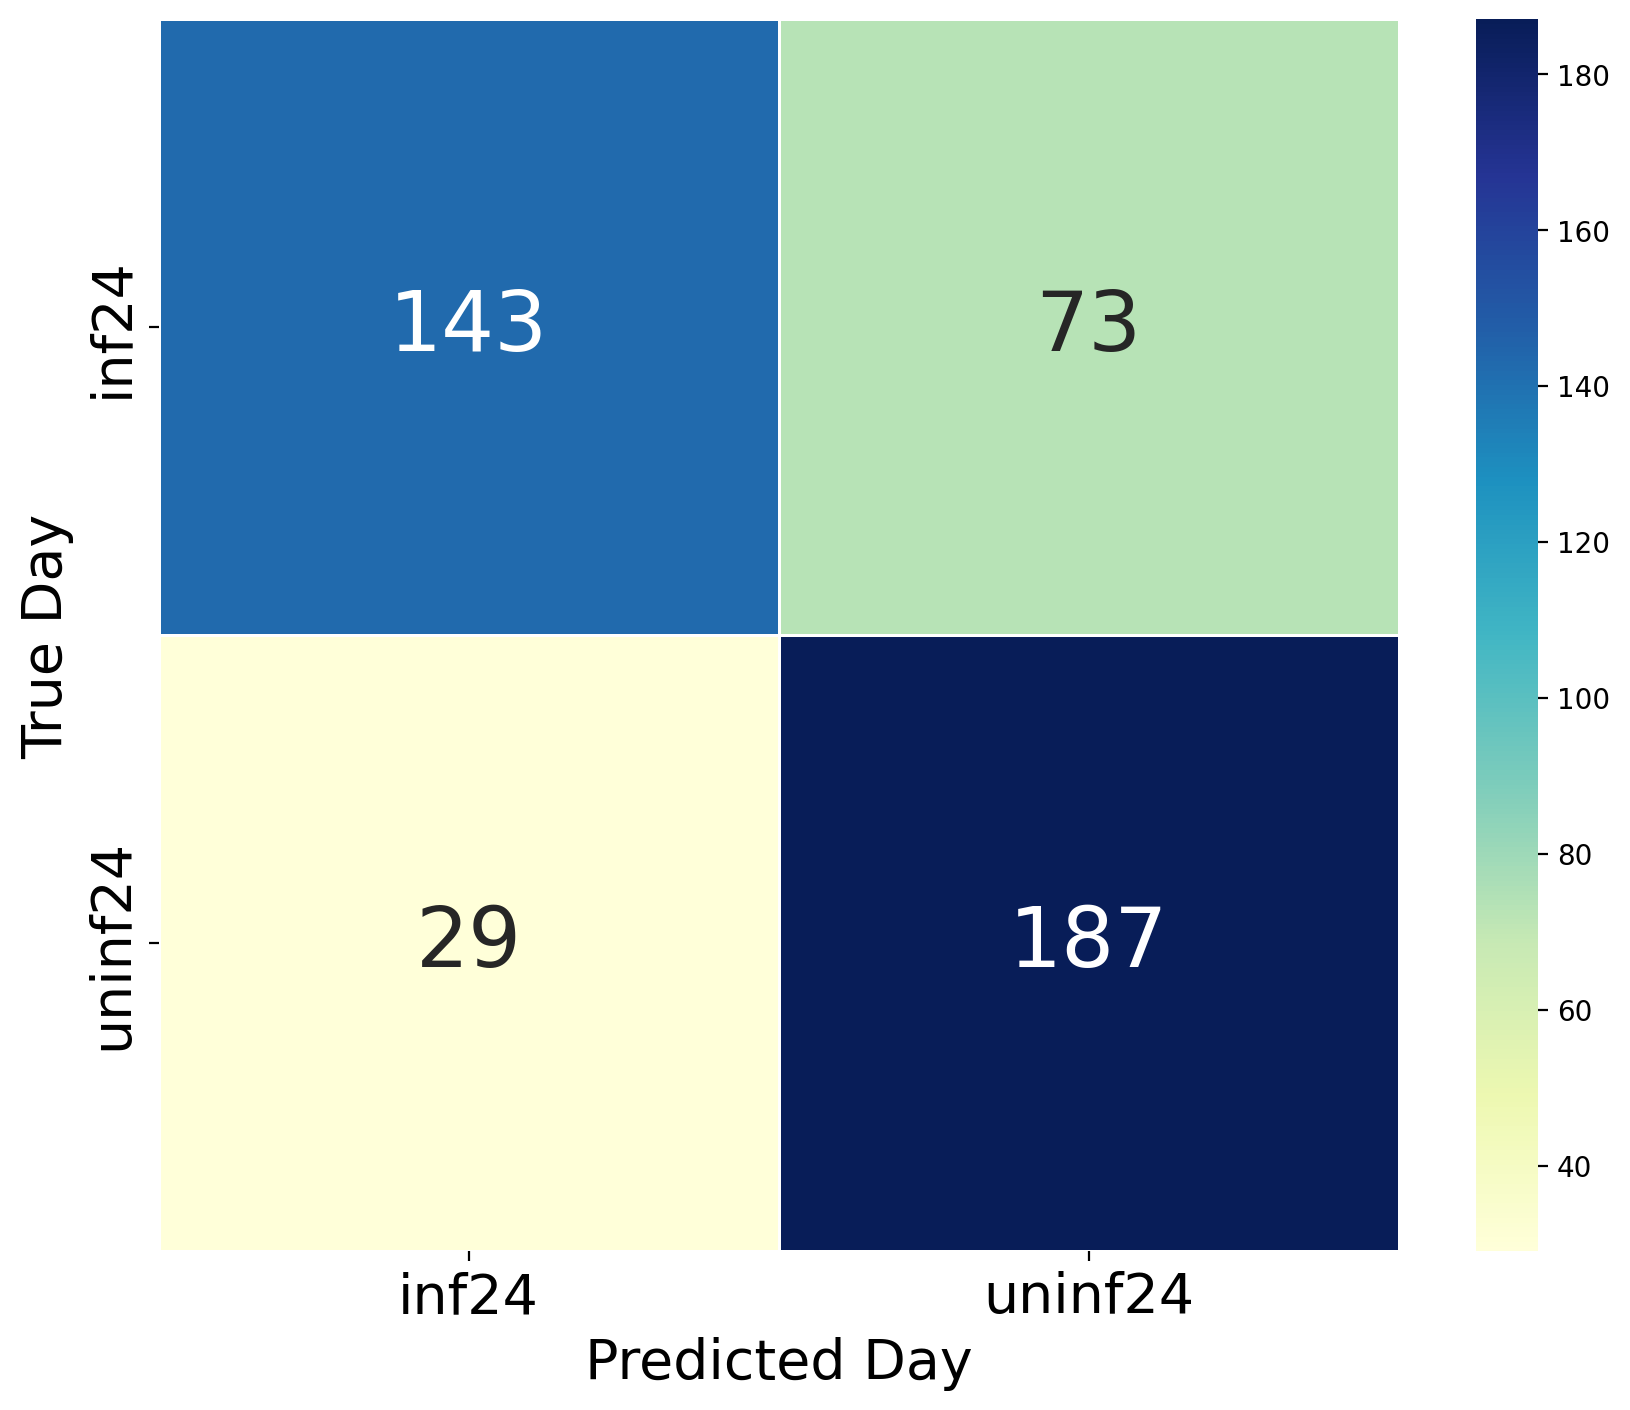

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your existing code to get pred_labels and true_labels
pred_labels = pred_test_last.argmax(1).cpu().numpy()
true_labels = label_test_last.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels (adjust this list to match your actual labels)
class_labels = ['inf24','uninf24']
# Plot confusion matrix
plt.figure(figsize=(10, 8))
#sns.set(font_scale=1.5)  # Adjust to increase the size of the annotations
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5,
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 30})
#sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Day", fontsize=20)  # Adjust to increase the size of the x-axis label
plt.ylabel("True Day", fontsize=20)  # Adjust to increase the size of the y-axis label
plt.xticks(fontsize=20)  # Adjust to increase the size of x-axis tick labels
plt.yticks(fontsize=20)  # Adjust to increase the size of y-axis tick labels
plt.show()

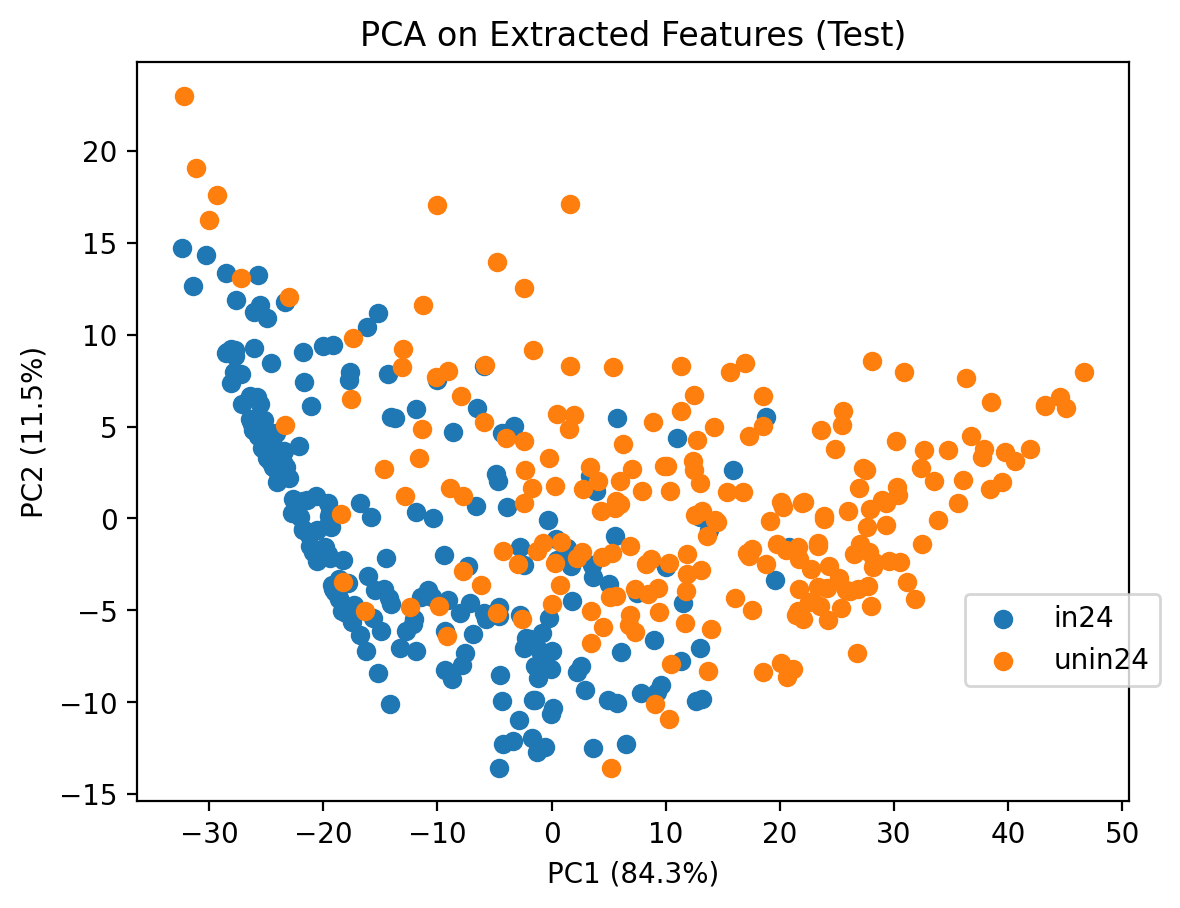

In [86]:
### PCA after Training ###
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch

# Ensure data is a torch.Tensor and on the same device as your model
device = next(feature_extractor.parameters()).device  # get model's device

# Convert NumPy arrays to torch tensors if needed
if isinstance(data_train, np.ndarray):
    data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
if isinstance(data_test, np.ndarray):
    data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

# Extract features without gradient tracking
with torch.no_grad():
    feature_train = feature_extractor(data_train).cpu().numpy()
    feature_test = feature_extractor(data_test).cpu().numpy()

# Fit PCA on training features
pca = PCA(n_components=2)
pca.fit(feature_train)

# Transform both training and test features
feature_train_pca = pca.transform(feature_train)
feature_test_pca = pca.transform(feature_test)


# ========== PCA Plot for test features ==========
fig, ax = plt.subplots()
for ii in range(len(ages)):
    idx = np.where(label_test == ii)
    ax.scatter(feature_test_pca[idx, 0], feature_test_pca[idx, 1], label=str(ages[ii]))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA on Extracted Features (Test)')
ax.legend(loc='upper left', bbox_to_anchor=(0.82, 0.3))
plt.show()

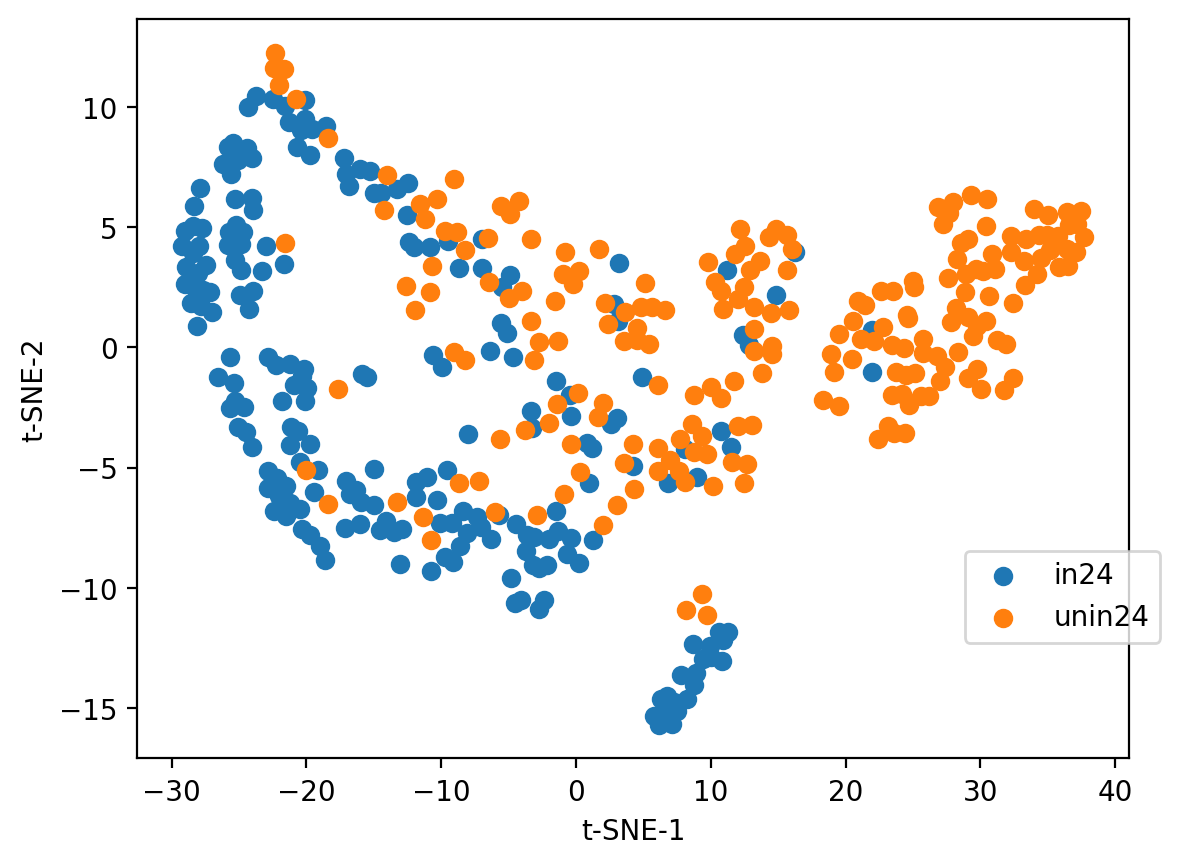

In [87]:
## t-SNE analysis with ANN training
from sklearn.manifold import TSNE
with torch.no_grad():
    dnn_feature_test = feature_extractor(data_test).numpy()

# Set the number of components to 2 for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
feature_test_embedded_tsne = tsne.fit_transform(dnn_feature_test)

fig, ax = plt.subplots()
for ii in range(len(ages)):  # Adjust the range based on your labels
    idx = np.where(label_test == ii)
    feature_now = feature_test_embedded_tsne[idx[0]]
    ax.scatter(feature_now[:, 0], feature_now[:, 1], label=str(ages[ii]))

ax.legend()
#plt.title('2D t-SNE')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.legend(loc='upper left', bbox_to_anchor=(0.82,0.3))
plt.show()


NameError: name 'os' is not defined